In [1]:
import numpy as np
import quadpy
from plind.contour_dict import equilateral_real, realcontour_nd
from plind.integrate import conintegrate
import matplotlib.pyplot as plt
# import sympy as sp
from scipy import optimize
from matplotlib.backends.backend_pdf import PdfPages
from scipy.misc import derivative as d
from scipy.integrate import solve_ivp,odeint,quadrature,quad
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
# import astropy.units as un
from scipy.interpolate import splprep, splev
# import astropy.constants as const
import importlib
# from autograd import elementwise_grad as egrad
# import openmesh as om
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dim = 2
scheme = quadpy.nsimplex.grundmann_moeller(dim, 3)

simps = np.stack([ 
        [[0.0, 0.0],
        [0.0, 1.0],
        [1.0, 0.0]],
    
        [[1.0, 1.0],
        [0.0, 1.0],
        [1.0, 0.0]]
        ], axis=-2)

val = scheme.integrate(
    lambda x: x[0]/x[0],
    simps
    )

print(simps.shape)
print(sum(val))

# answer should be 1

(3, 2, 2)
(0.9999999999999991+0j)


In [4]:
dim = 3
scheme = quadpy.nsimplex.grundmann_moeller(dim, 3)

simps = np.stack([ 
        [[0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [1.0, 0.0, 0.0],
        [0.5, 0.5, 1.0]],
    
        [[1.0, 1.0, 0.0],
        [0.0, 1.0, 0.0],
        [1.0, 0.0, 0.0],
        [0.5, 0.5, 1.0]],
        ], axis=-2)

val = scheme.integrate(
    lambda x: x[0]/x[0],
    simps
    )

print(sum(val))

# answer should be 1/3

(0.33333333333333326+0j)


In [5]:
dim = 3
scheme = quadpy.nsimplex.grundmann_moeller(dim, 3)

simps = np.stack([ 
        [[0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [1.0, 0.0, 0.0],
        [0.5, 0.5, 1.0]],
    
        [[1.0, 1.0, 0.0],
        [0.0, 1.0, 0.0],
        [1.0, 0.0, 0.0],
        [0.5, 0.5, 1.0]],
        ], axis=-2)*(1+1j)

val = scheme.integrate(
    lambda x: x[0]/x[0],
    simps
    )

print(sum(val))
print((1/3)*(1+1j)**3)

(0.6666666666666669-0.6666666666666667j)
(-0.6666666666666666+0.6666666666666666j)


In [6]:
contour = realcontour_nd(10, (-2,2,-2,2,-2,2))
contour.points = contour.points*1j

intgrl, err = conintegrate(lambda x: np.exp(10*(x[0]**2+x[1]**2+x[2]**2)), contour)


print(intgrl, err)

(7.242886264609137e-11+0.17607533557071847j) 1.1359874737548736e-05


In [7]:
def transform(points, simplex):
    """Transform the points `xi` from the reference simplex onto `simplex`.
    """
    # For n == 2:
    # x = (
    #     + outer(triangle[0].T, 1.0 - xi[0] - xi[1])
    #     + outer(triangle[1].T, xi[0])
    #     + outer(triangle[2].T, xi[1])
    #     )
    return np.dot(simplex, points)

In [8]:
scheme = quadpy.nsimplex.grundmann_moeller(dim, 3)

f = lambda x: x[0]
simplex = np.array([[0.0, 0.0],
        [0.0, 1.0],
        [1.0, 0.0]]) 

flt = np.vectorize(float)
simplex = np.asarray(simplex)
x = transform(flt(scheme.points).T, simplex.T)

fx = np.asarray(f(x))

ValueError: shapes (2,3) and (4,35) not aligned: 3 (dim 1) != 4 (dim 0)

In [9]:
x[0]

NameError: name 'x' is not defined

In [10]:
np.dot(simplex.T, flt(scheme.points).T)

ValueError: shapes (2,3) and (4,35) not aligned: 3 (dim 1) != 4 (dim 0)

In [11]:
simplex.T

array([[0., 0., 1.],
       [0., 1., 0.]])

In [13]:
contour = equilateral_real(20, (-0.5,0.5,-0.5,0.5))

In [14]:
contour.simplices

array([[  0,   1,  20],
       [ 20,  21,   1],
       [  1,   2,  21],
       ...,
       [397, 398, 378],
       [378, 379, 398],
       [398, 399, 379]])

In [15]:
simps = contour.points[contour.simplices]

In [91]:
simps = np.stack(simps, axis=-2)

In [92]:
val = scheme.integrate(
    lambda x: x[0]/x[0],
    simps
    )

In [94]:
sum(val)

0.9999999999999918

In [95]:
contour.ndim

2

# Check the refinement algorithm in 2D

In [563]:
def plot_current(points, simplices, edges, bad_edges):
    plt.figure(figsize=(3,3))
    plt.tripcolor(points[:,0],points[:,1],simplices,np.ones(simplices.shape[0]),alpha=0.2)
    plt.scatter(points[:,0],points[:,1],alpha=0.5,color='k',zorder=20,s=200)
    for i, point in enumerate(points):
        plt.text(point[0]+0.05,point[1]+0.05,str(i),fontsize=20,zorder=100)
    for i in range(edges.shape[0]):
        plt.plot(points[edges[i]][:,0],points[edges[i]][:,1],color='b',lw=4,alpha=0.5)
    for i in range(bad_edges.shape[0]):
        plt.plot(points[bad_edges[i]][:,0],points[bad_edges[i]][:,1],color='r',ls='--')
    return
def init_testcase():
    points = np.array([[0.,0.],[1,0],[1,1],[0,1],[0,-1],[-1,1],[-1,-1],[0,2]])
    simplices = np.array([[0,1,2],[0,2,3],[4,1,0],[5,0,3],[5,0,4],[5,6,4],[7,3,2],[5,3,7]])
    edges = np.array([[0,1],[1,2],[0,2],[0,3],[0,4],[5,0],[3,5],[5,4],[4,6],[5,6],[7,3],[2,7],[5,7],[2,3],[1,4]])
    bad_edges = np.array([[0,2],[0,1],[0,5],[5,4],[5,6],[6,4],[3,7]])
    return points, simplices, edges, bad_edges

In [564]:
points, simplices, edges, bad_edges = init_testcase()
ndim = 2

<IPython.core.display.Javascript object>


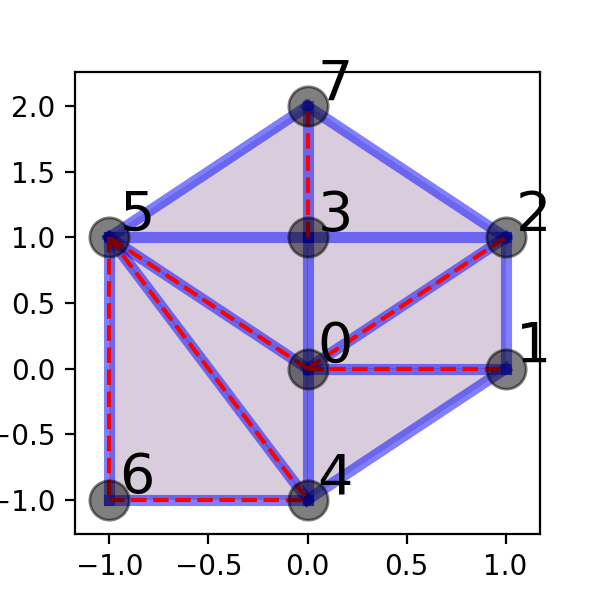

In [565]:
plot_current(points,simplices,edges,bad_edges)

In [566]:
used_simps = np.array([], dtype=np.int)
uni_bad_edges = np.array([], dtype=np.int)
uni_bad_simps = np.empty((0, ndim+1), int)#np.array([], dtype=np.int)

# The surface becomes inconsistent if two edges within the same simplex are flagged at once.
# To combat this, only the first edge is split, and the second is assumed to be caught
# by the subsequent time step
for i, bad_edge in enumerate(bad_edges):
    # Keep track of the simplices associated with an edge
    simplices_tag = np.isin(simplices, bad_edge).sum(axis=-1) > 1
    simplices_tag = np.where(simplices_tag)[0] 

    if not np.any(np.in1d(simplices_tag, used_simps)):  # Check if we have used this simplex
        # Flag simplices_tag to not reuse simplices
        used_simps = np.append(used_simps, simplices_tag)
        # Add edge to new bad edge array
        uni_bad_edges = np.append(uni_bad_edges, bad_edge)
        # Remove bad edges from the list of edges
        edges_tag = np.isin(edges, bad_edge).sum(axis=-1) == 2
        edges = edges[~(edges_tag)]

        # Add simplice(s) with the proper extras populated
        uni_bad_simps = np.append(uni_bad_simps, simplices[simplices_tag], axis=0)
#         for j in range(ndim):
#             if np.size(simplices_tag) > j:
#                 uni_bad_simps = np.append(uni_bad_simps, simplices[simplices_tag[j]], axis=0)

# The only edges this function treats and removes are uni_bad_edges,
# that is, the edges that are unique with respect to their simplices. 
uni_bad_simps = uni_bad_simps.reshape(-1, ndim+1)
uni_bad_edges = uni_bad_edges.reshape(-1, 2)

# Delete all the bad edges 
simplices = np.delete(simplices, used_simps, axis=0)


In [567]:
uni_bad_edges

array([[0, 2],
       [0, 5],
       [5, 6],
       [3, 7]])

<IPython.core.display.Javascript object>


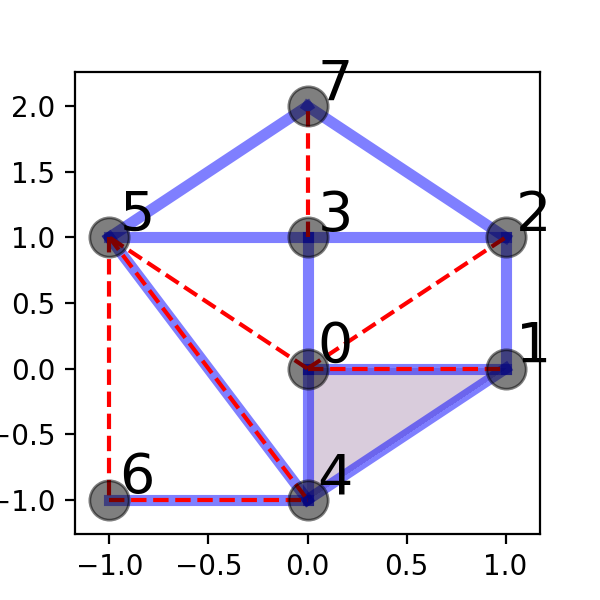

In [568]:
plot_current(points,simplices,edges,bad_edges)

<IPython.core.display.Javascript object>


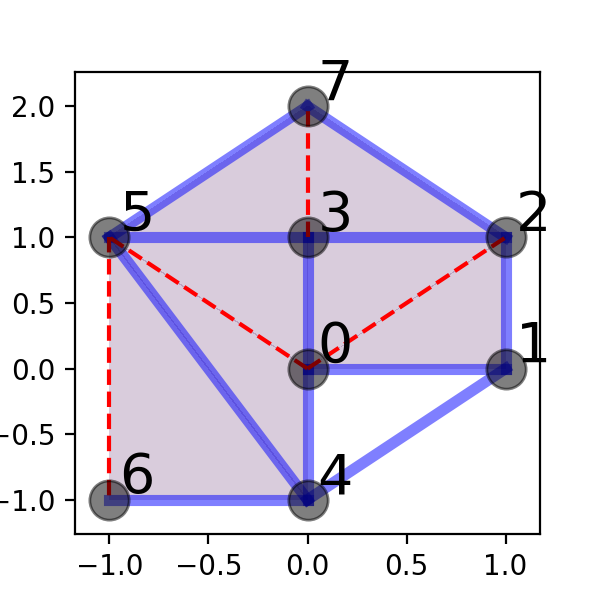

In [569]:
plot_current(points,uni_bad_simps,edges,uni_bad_edges)

In [570]:
# Add the midpoints of all the bad edges
midpts_ind = np.arange(np.shape(points)[0], np.shape(points)[0]+np.shape(uni_bad_edges)[0], 1, dtype=np.int)
midpts = (points[uni_bad_edges[:, 0]] + points[uni_bad_edges[:, 1]])/2
points = np.append(points, midpts, axis=0)

<IPython.core.display.Javascript object>


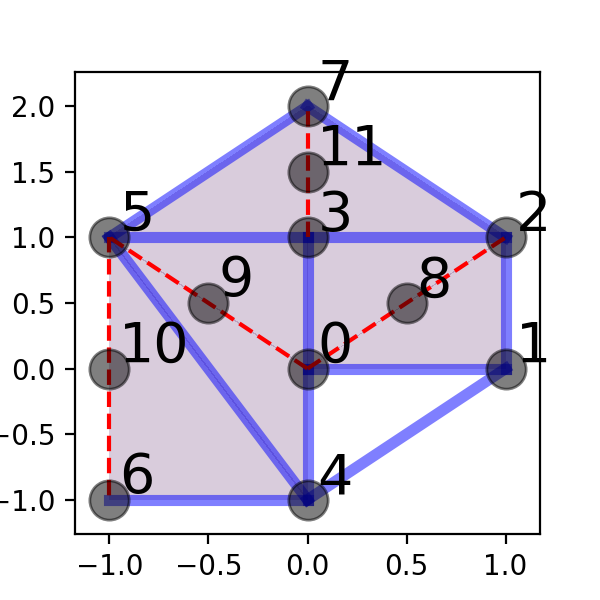

In [571]:
plot_current(points,uni_bad_simps,edges,uni_bad_edges)

In [572]:
# Add the two edges that replace all the bad edges
edges_1 = np.sort(np.append(midpts_ind, uni_bad_edges[:, 0], axis=0).reshape(2,-1).T, axis=1)
edges_2 = np.sort(np.append(midpts_ind, uni_bad_edges[:, 1], axis=0).reshape(2,-1).T, axis=1)
edges = np.concatenate((edges, edges_1, edges_2), axis=0)

<IPython.core.display.Javascript object>


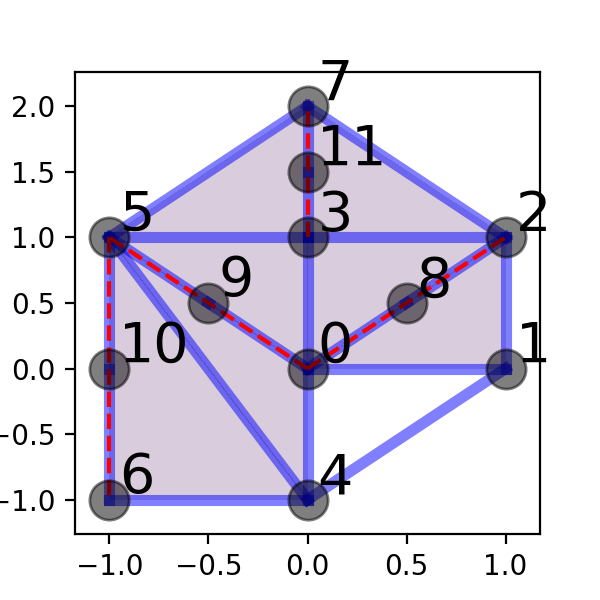

In [573]:
plot_current(points,uni_bad_simps,edges,uni_bad_edges)

In [574]:
for i, bad_edge in enumerate(uni_bad_edges):
        # Get all points in the simplex not associated to the edge ("outliers")
        outliers = uni_bad_simps[np.isin(uni_bad_simps, bad_edge, invert=True) *
                    (np.isin(uni_bad_simps, bad_edge, invert=True).sum(axis=-1)==ndim+1-2)[:, np.newaxis]]
        uni_outliers = np.unique(outliers)
        
        # ndim - 1 outliers will exist in every simplex
        if ndim == 1:
            num_simps = 1
        else:
            num_simps = int(np.size(outliers)/(ndim-1))
        num_outliers=np.size(uni_outliers)
        
        outliers = np.reshape(outliers, [num_simps, ndim-1])
        uni_outliers = np.reshape(uni_outliers, [num_outliers,1])

        # add new edge for every outlier
        edges_outliers = np.sort(np.append(uni_outliers, midpts_ind[i]*np.ones([num_outliers, 1], dtype=np.int),axis=1), axis=0)
        edges_outliers = edges_outliers.astype(np.int)
        edges = np.append(edges, edges_outliers, axis=0)

        # Simplices per outlier row
        simp_1 = np.sort(np.concatenate(( midpts_ind[i]*np.ones([num_simps, 1], dtype=np.int),outliers,bad_edge[0]*np.ones([num_simps, 1], dtype=np.int)),axis=1), axis=1)
        simp_2 = np.sort(np.concatenate(( midpts_ind[i]*np.ones([num_simps, 1], dtype=np.int),outliers,bad_edge[1]*np.ones([num_simps, 1], dtype=np.int)),axis=1), axis=1)

        simplices = np.concatenate((simplices, simp_1, simp_2), axis=0)

<IPython.core.display.Javascript object>


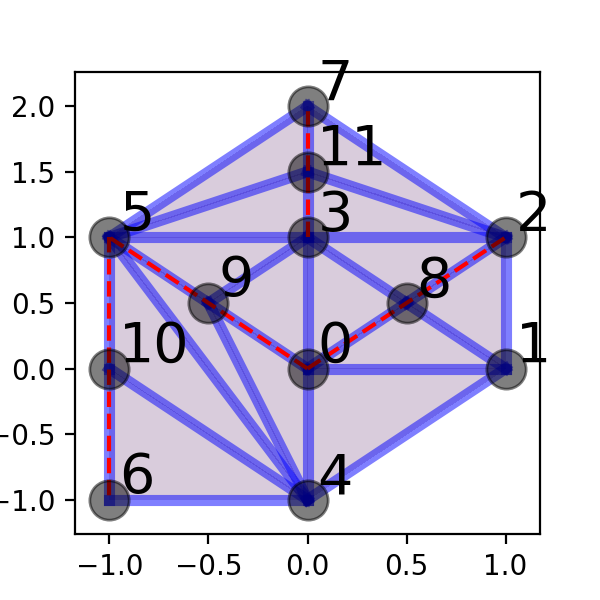

In [575]:
plot_current(points,simplices,edges,uni_bad_edges)

# Check refinement in 3D

In [534]:
def plot_current(points, simplices, edges, bad_edges):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    vertices = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
    ax.scatter(points[:,0],points[:,1],points[:,2])
#     for simp in simplices:
#         pnts = points[simp]
#         poly3d = [[pnts[vertices[ix][iy]] for iy in range(len(vertices[0]))] for ix in range(len(vertices))]
#         ax.add_collection3d(Poly3DCollection(poly3d, facecolors='w', linewidths=1, alpha=0.5))
#         ax.add_collection3d(Line3DCollection(poly3d, colors='k', linewidths=0.2, linestyles=':'))
    for i in range(edges.shape[0]):
        ax.plot(points[edges[i]][:,0],points[edges[i]][:,1],points[edges[i]][:,2],color='b',lw=4,alpha=0.5)
    for i in range(bad_edges.shape[0]):
        plt.plot(points[bad_edges[i]][:,0],points[bad_edges[i]][:,1],points[bad_edges[i]][:,2],color='r',ls='--')     
    plt.show()
def init_testcase():
    points = np.array([[0.,0.,0.],[1.,0.,0.],[0.5,1.0,0.],[0.5,0.5,1.0]])
    simplices = np.array([[0,1,2,3]])
    edges = np.array([[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]])
    bad_edges = np.array([[0,1]])
    return points, simplices, edges, bad_edges
def init_testcase_2():
#     points = np.array([[0.  , 0.  , 0.  ],
#        [1.  , 0.  , 0.  ],
#        [0.5 , 1.  , 0.  ],
#        [0.5 , 0.5 , 1.  ],
#        [0.5 , 0.  , 0.  ],
#        [0.5 , 0.25, 0.5 ]])
#     simplices = np.array([[0, 2, 3, 5],
#        [1, 2, 3, 5],
#        [0, 2, 4, 5],
#        [1, 2, 4, 5]])
#     edges = np.array([[0, 2],
#        [0, 3],
#        [1, 2],
#        [1, 3],
#        [2, 3],
#        [0, 4],
#        [1, 4],
#        [2, 4],
#        [3, 5],
#        [4, 5],
#        [0, 5],
#        [1, 5],
#        [2, 5]])
#     bad_edges = np.array([[2,5]])
    points = np.array([[0.  , 0.  , 0.  ],
       [0.5  , 0.  , 0.  ],
       [1. , 0.  , 0.  ],
       [0.5 , 1.0 , 0.  ],
       [0.5 , 0.  , 1.  ],
       [0.5 , -1., 0. ]])
    simplices = np.array([[0, 1, 3, 4],
       [1, 2, 3, 4],
       [0, 1, 4, 5],
       [1, 2, 4, 5]])
    edges = np.array([[0, 1],
       [0, 3],
       [1, 3],
       [1, 2],
       [2, 3],
       [0, 5],
       [1, 5],
       [0, 4],
       [3, 4],
       [1, 4],
       [2, 4],
       [5, 4],
       [5, 2]])
    bad_edges = np.array([[1,4],[0,5]])
    return points, simplices, edges, bad_edges
    

In [535]:
points, simplices, edges, bad_edges = init_testcase_2()
ndim = 3

<IPython.core.display.Javascript object>


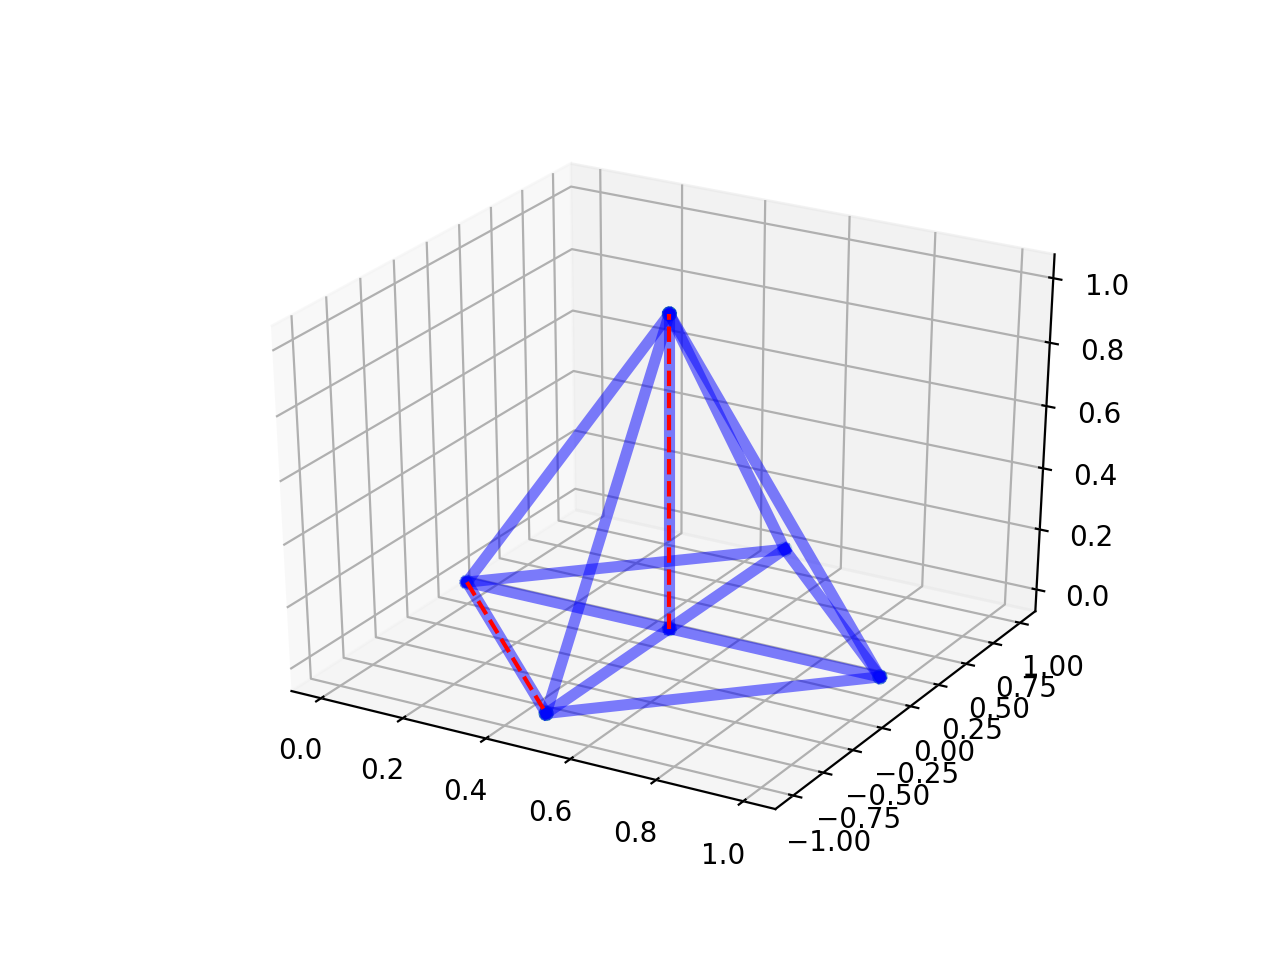

In [536]:
plot_current(points, simplices, edges, bad_edges)

In [537]:
used_simps = np.array([], dtype=np.int)
uni_bad_edges = np.array([], dtype=np.int)
uni_bad_simps = np.empty((0, ndim+1), int)#np.array([], dtype=np.int)

# The surface becomes inconsistent if two edges within the same simplex are flagged at once.
# To combat this, only the first edge is split, and the second is assumed to be caught
# by the subsequent time step
for i, bad_edge in enumerate(bad_edges):
    # Keep track of the simplices associated with an edge
    simplices_tag = np.isin(simplices, bad_edge).sum(axis=-1) > 1
    simplices_tag = np.where(simplices_tag)[0] 

    if not np.any(np.in1d(simplices_tag, used_simps)):  # Check if we have used this simplex
        # Flag simplices_tag to not reuse simplices
        used_simps = np.append(used_simps, simplices_tag)
        # Add edge to new bad edge array
        uni_bad_edges = np.append(uni_bad_edges, bad_edge)
        # Remove bad edges from the list of edges
        edges_tag = np.isin(edges, bad_edge).sum(axis=-1) == 2
        edges = edges[~(edges_tag)]

        # Add simplice(s) with the proper extras populated
        uni_bad_simps = np.append(uni_bad_simps, simplices[simplices_tag], axis=0)
#         for j in range(ndim):
#             if np.size(simplices_tag) > j:
#                 uni_bad_simps = np.append(uni_bad_simps, simplices[simplices_tag[j]], axis=0)

# The only edges this function treats and removes are uni_bad_edges,
# that is, the edges that are unique with respect to their simplices. 
uni_bad_simps = uni_bad_simps.reshape(-1, ndim+1)
uni_bad_edges = uni_bad_edges.reshape(-1, 2)

# Delete all the bad edges 
simplices = np.delete(simplices, used_simps, axis=0)


In [538]:
uni_bad_simps

array([[0, 1, 3, 4],
       [1, 2, 3, 4],
       [0, 1, 4, 5],
       [1, 2, 4, 5]])

<IPython.core.display.Javascript object>


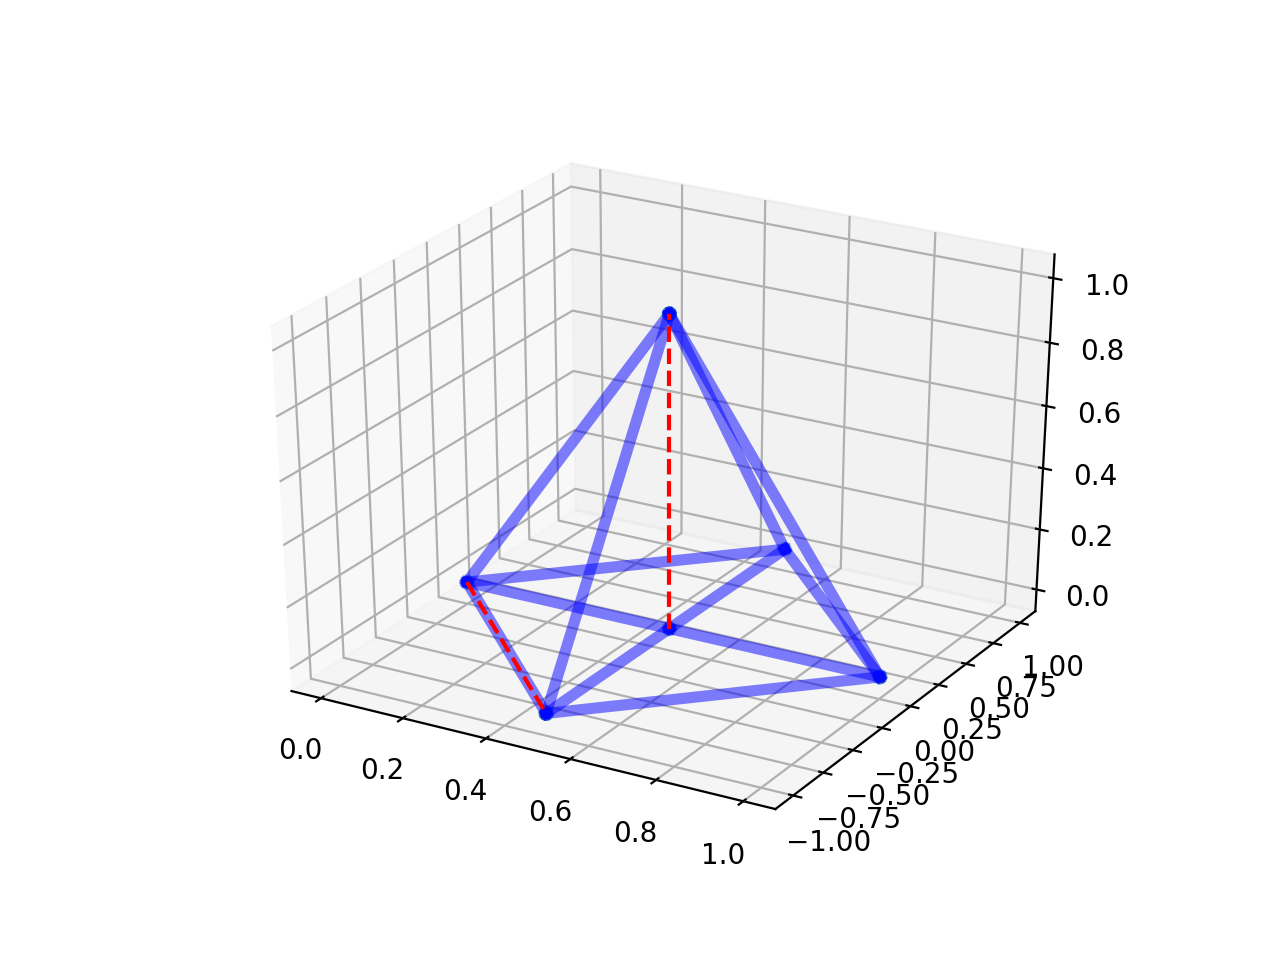

In [539]:
plot_current(points,simplices,edges,bad_edges)

<IPython.core.display.Javascript object>


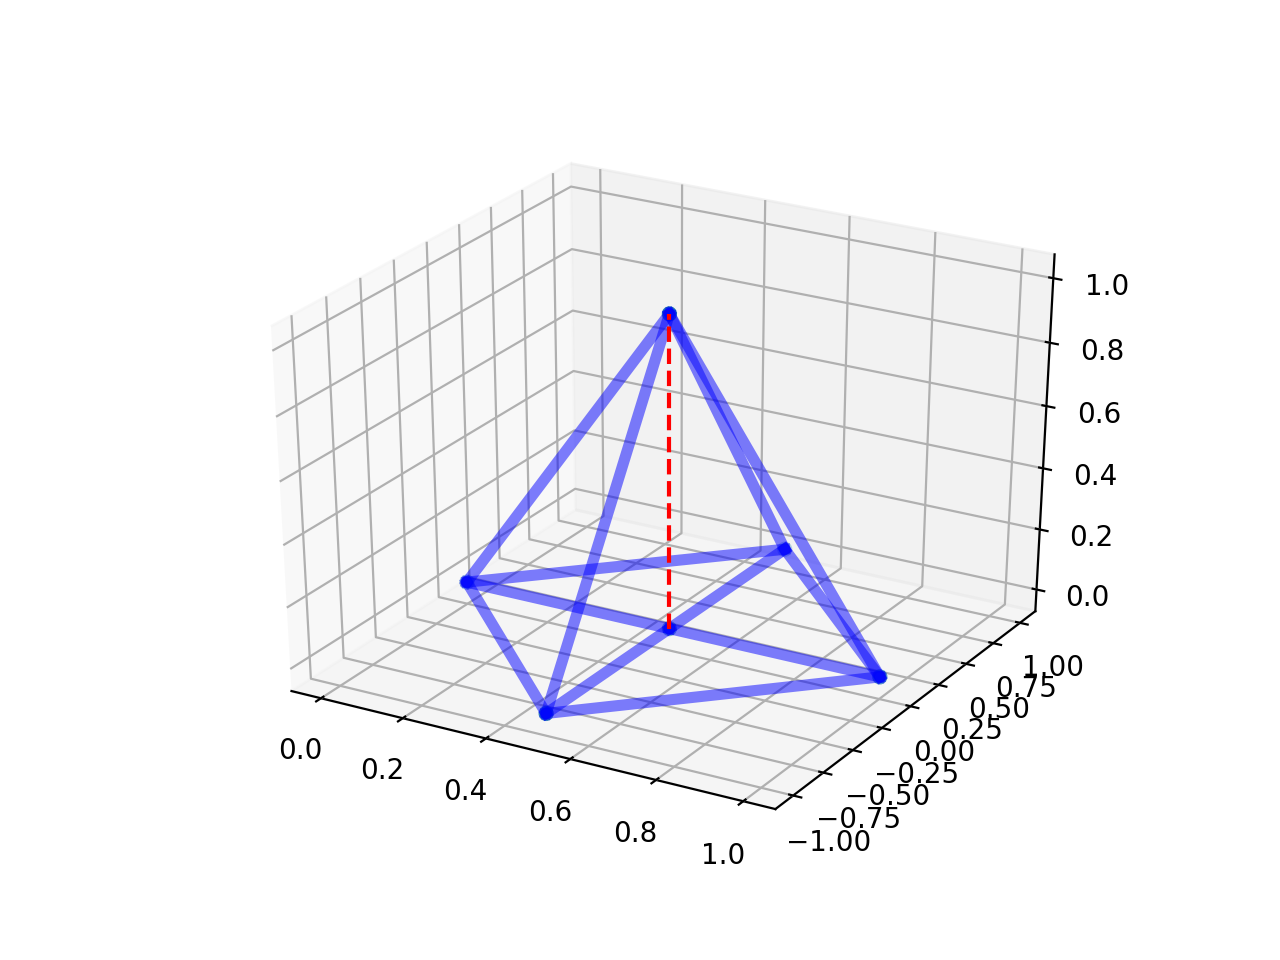

In [540]:
plot_current(points,uni_bad_simps,edges,uni_bad_edges)

In [541]:
# Add the midpoints of all the bad edges
midpts_ind = np.arange(np.shape(points)[0], np.shape(points)[0]+np.shape(uni_bad_edges)[0], 1, dtype=np.int)
midpts = (points[uni_bad_edges[:, 0]] + points[uni_bad_edges[:, 1]])/2
points = np.append(points, midpts, axis=0)

<IPython.core.display.Javascript object>


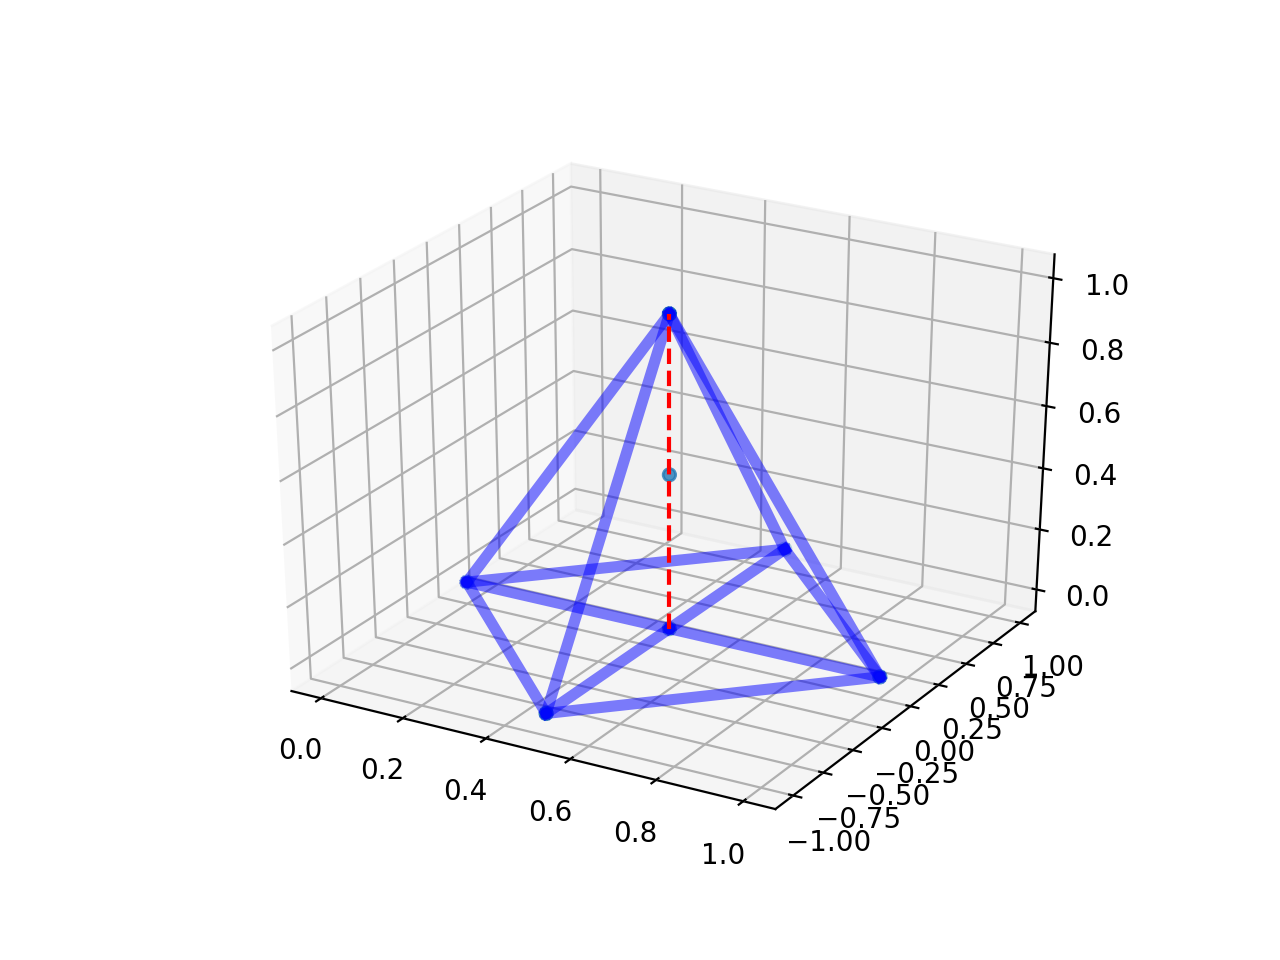

In [542]:
plot_current(points,uni_bad_simps,edges,uni_bad_edges)

In [543]:
# Add the two edges that replace all the bad edges
edges_1 = np.sort(np.append(midpts_ind, uni_bad_edges[:, 0], axis=0).reshape(2,-1).T, axis=1)
edges_2 = np.sort(np.append(midpts_ind, uni_bad_edges[:, 1], axis=0).reshape(2,-1).T, axis=1)
edges = np.concatenate((edges, edges_1, edges_2), axis=0)

<IPython.core.display.Javascript object>


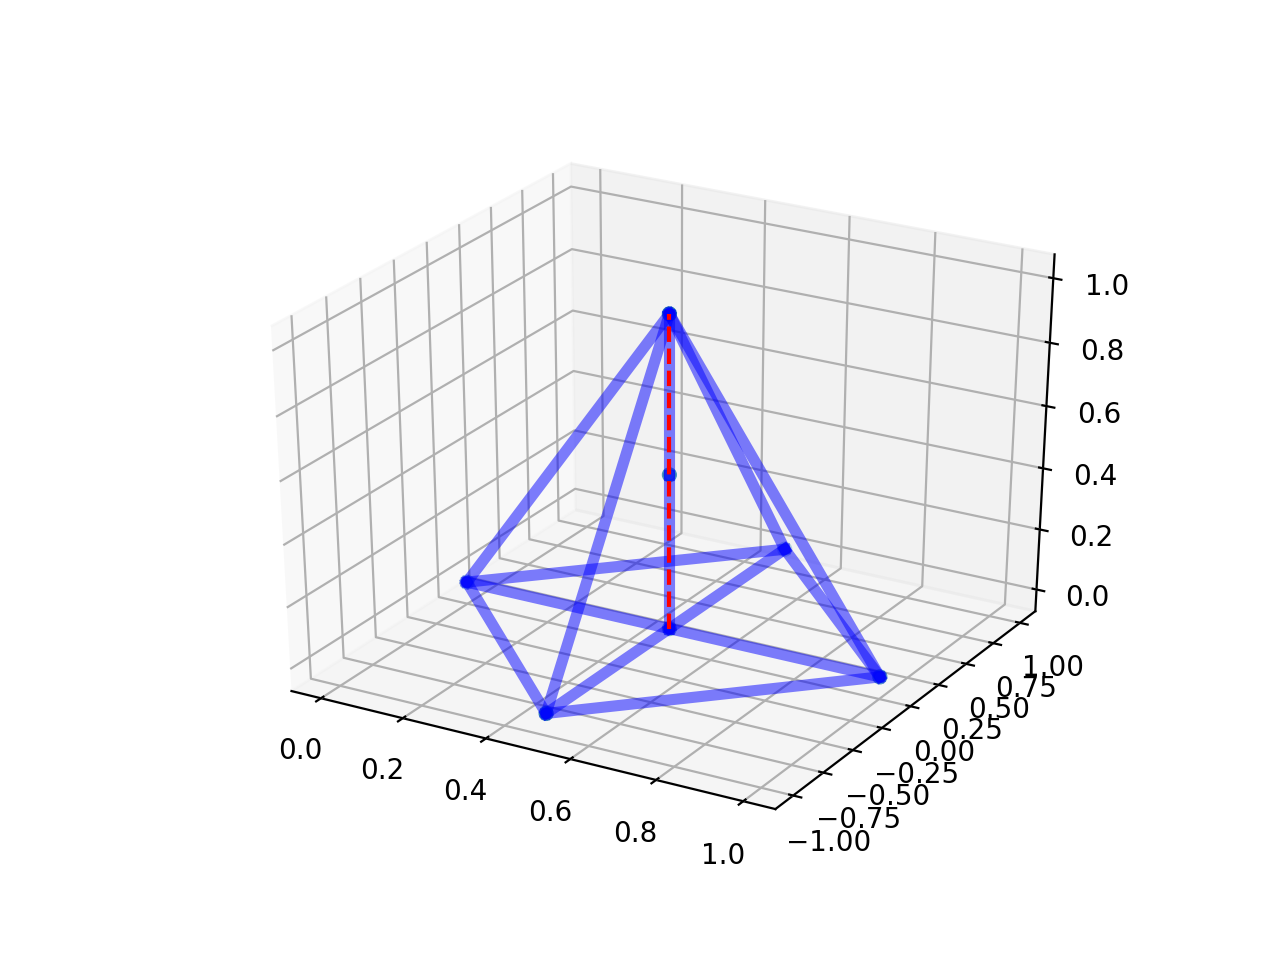

In [544]:
plot_current(points,uni_bad_simps,edges,uni_bad_edges)

In [545]:
for i, bad_edge in enumerate(uni_bad_edges):
        # Get all points in the simplex not associated to the edge ("outliers")
        outliers = uni_bad_simps[np.isin(uni_bad_simps, bad_edge, invert=True) *
                    (np.isin(uni_bad_simps, bad_edge, invert=True).sum(axis=-1)==ndim+1-2)[:, np.newaxis]]
        uni_outliers = np.unique(outliers)
        
        # ndim - 1 outliers will exist in every simplex
        if ndim == 1:
            num_simps = 1
        else:
            num_simps = int(np.size(outliers)/(ndim-1))
        num_outliers=np.size(uni_outliers)
        
        outliers = np.reshape(outliers, [num_simps, ndim-1])
        uni_outliers = np.reshape(uni_outliers, [num_outliers,1])

        # add new edge for every outlier
        edges_outliers = np.sort(np.append(uni_outliers, midpts_ind[i]*np.ones([num_outliers, 1], dtype=np.int),axis=1), axis=0)
        edges_outliers = edges_outliers.astype(np.int)
        edges = np.append(edges, edges_outliers, axis=0)

        # Simplices per outlier row
        simp_1 = np.sort(np.concatenate(( midpts_ind[i]*np.ones([num_simps, 1], dtype=np.int),outliers,bad_edge[0]*np.ones([num_simps, 1], dtype=np.int)),axis=1), axis=1)
        simp_2 = np.sort(np.concatenate(( midpts_ind[i]*np.ones([num_simps, 1], dtype=np.int),outliers,bad_edge[1]*np.ones([num_simps, 1], dtype=np.int)),axis=1), axis=1)

        simplices = np.concatenate((simplices, simp_1, simp_2), axis=0)

<IPython.core.display.Javascript object>


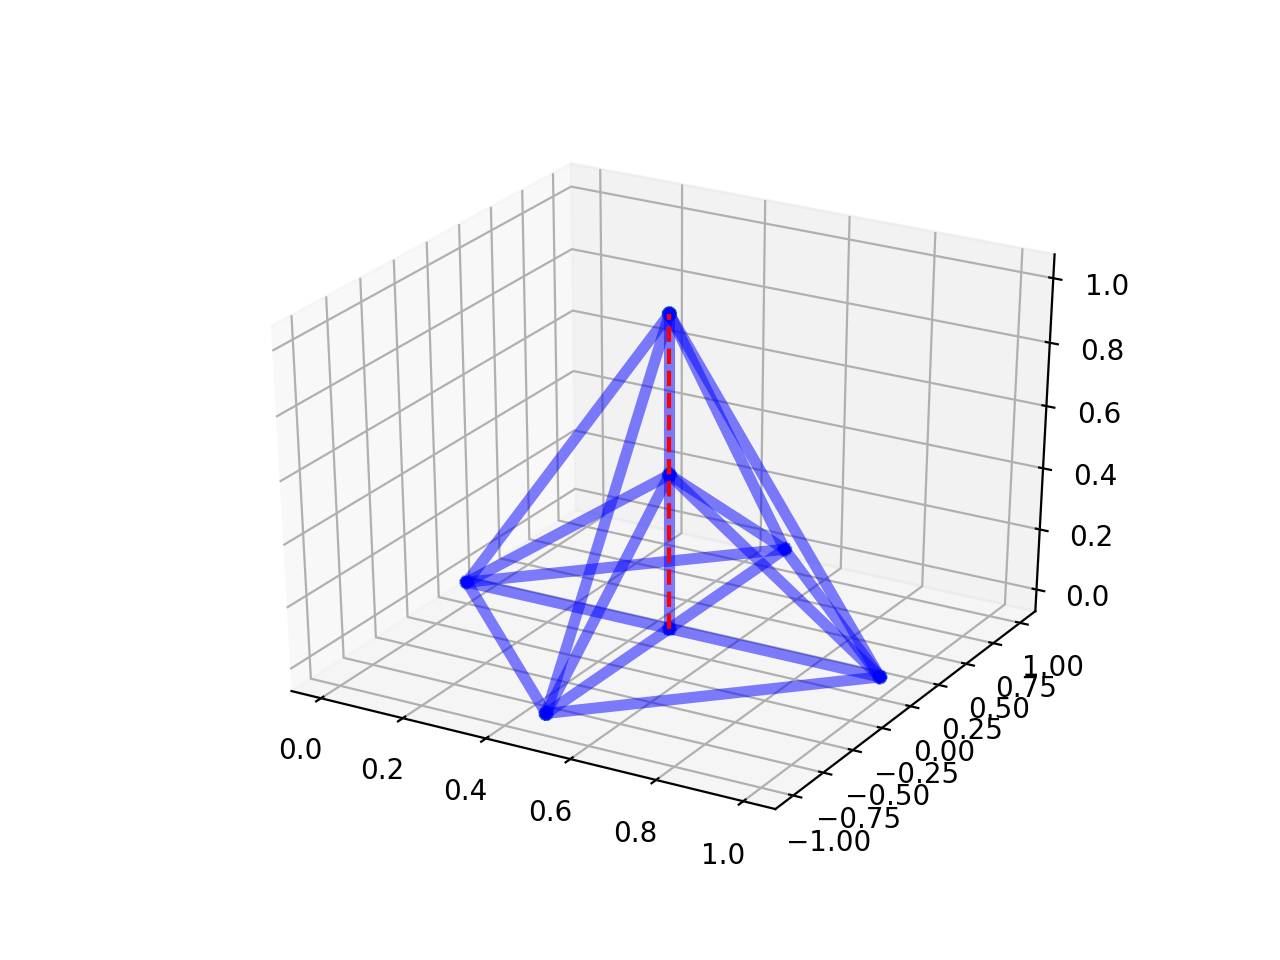

In [546]:
plot_current(points,simplices,edges,uni_bad_edges)

In [547]:
points

array([[ 0. ,  0. ,  0. ],
       [ 0.5,  0. ,  0. ],
       [ 1. ,  0. ,  0. ],
       [ 0.5,  1. ,  0. ],
       [ 0.5,  0. ,  1. ],
       [ 0.5, -1. ,  0. ],
       [ 0.5,  0. ,  0.5]])

In [548]:
simplices

array([[0, 1, 3, 6],
       [1, 2, 3, 6],
       [0, 1, 5, 6],
       [1, 2, 5, 6],
       [0, 3, 4, 6],
       [2, 3, 4, 6],
       [0, 4, 5, 6],
       [2, 4, 5, 6]])

In [549]:
edges

array([[0, 1],
       [0, 3],
       [1, 3],
       [1, 2],
       [2, 3],
       [0, 5],
       [1, 5],
       [0, 4],
       [3, 4],
       [2, 4],
       [5, 4],
       [5, 2],
       [1, 6],
       [4, 6],
       [0, 6],
       [2, 6],
       [3, 6],
       [5, 6]])

In [516]:
len(edges)

18